# Module import

In [37]:
# Load modules and set-up test problem
import sys
# sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

import cuqi
from cuqi.testproblem import Deconvolution1D, Deconvolution2D
from cuqi.distribution import Gaussian, Gamma, ModifiedHalfNormal, JointDistribution
from cuqi.implicitprior import RegularizedGaussian, RegularizedGMRF, RegularizedUniform
from cuqi.sampler import RegularizedLinearRTO, Gibbs, Conjugate

# Set seed
np.random.seed(41)

print("Pre-implemented constraints: ", RegularizedGaussian.constraint_options())
print("Pre-implemented regularization: ", RegularizedGaussian.regularization_options())

# Create a new sampler class with preset parameters
def make_RegularizedLinearRTO(x0 = None, maxit = 100, stepsize = "automatic", tradeoff = 10.0, adaptive = True):
    # Wrapper to tune the parameters
    class _RegularizedLinearRTO(RegularizedLinearRTO):
        def __init__(self, target):
            super().__init__(target, x0=x0, maxit=maxit, stepsize = stepsize, tradeoff = tradeoff, adaptive = adaptive)

    return _RegularizedLinearRTO


Pre-implemented constraints:  ['nonnegativity', 'box']
Pre-implemented regularization:  ['l1', 'TV']


In [2]:
# Poisson solver
from utils import PoissonEfficient

In [ ]:
import matplotlib 

fontsize = 20
legendfontsize = 18

matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 

# Exact solution and noisy data

([<matplotlib.axis.XTick at 0x7fffb7141cd0>,
 [Text(0.0, 0, '0'),
  Text(0.25, 0, '0.25'),
  Text(0.5, 0, '0.5'),
  Text(0.75, 0, '0.75'),
  Text(1.0, 0, '1')])

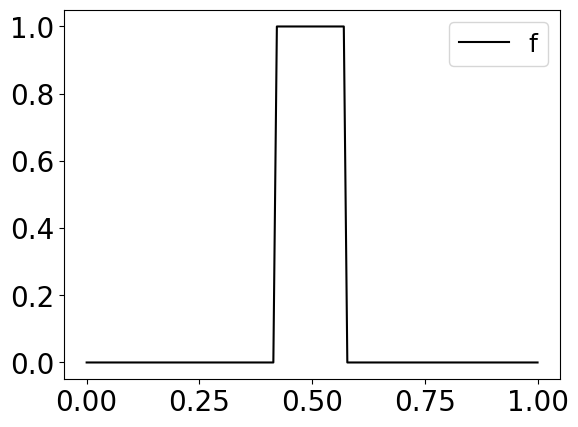

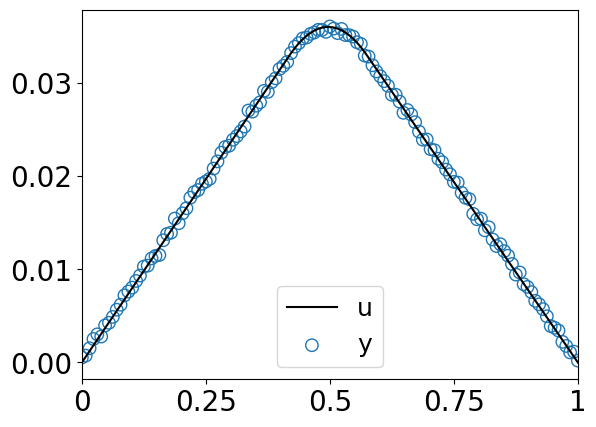

In [66]:
np.random.seed(0)

# %%
nx = 128
poisson = PoissonEfficient(nx)

signal_index = 0

if signal_index == 1:
    # truncated sine wave
    xx = np.linspace(0, 1, 128+1)
    x_exact = np.sin(4*np.pi*xx)
    x_exact[np.where(x_exact < 0)]=0
else:
    # square wave
    x_exact = np.zeros(nx+1)
    x_exact[int(nx/2)-10:int(nx/2)+10] = 1

    # x_exact[25:35] = 0.5

    # x_exact[45:60] = 1

    # x_exact[80:95] = 0.8

plt.figure()
plt.plot(np.linspace(0,1,129), x_exact, label='f', color="k")
plt.legend(fontsize=legendfontsize, loc="upper right")

# %%
y_exact = poisson.forward(x_exact)

noise_scale = 3e-4#0.25e-3#1e-3#3e-3#0.001#0.002 #0.001 #0.003 #0.003 #0.002
noise = noise_scale*np.random.randn(y_exact.size)
y_data = y_exact + noise
# %%
plt.figure()
plt.plot(np.linspace(0,1,129), y_exact, label='u', color="k")
# plt.plot(np.linspace(0,1,129), y_data, 'o', label='y', color="C2")
plt.scatter(np.linspace(0,1,129), y_data, s=80, facecolors='none', edgecolors='C0', label="y")
plt.legend(fontsize=legendfontsize, loc="lower center")
# plt.ylim([0,0.05])
plt.xlim([0, 1])
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['0', '0.25', '0.5', '0.75', '1'])

# Common paramters

In [67]:
A = cuqi.model.LinearModel(poisson.forward, adjoint=poisson.adjoint, range_geometry=nx+1, domain_geometry=nx+1)

In [68]:
# Fixed (known) variance for the noise
measure_variance = np.ones(nx+1)*noise_scale**2

In [69]:
num_samples = 1000
num_burnin = 200

# Experiments
## EX1. Regularized GMRF + Gibbs to learn precision of GMRF

In [70]:
# Regularized GMRF with Gibbs (to learn precision of GMRF as well)
np.random.seed(0)
d = Gamma(1, 1e-4)
x = RegularizedGMRF(np.zeros(nx+1), prec = lambda d:d, constraint = "nonnegativity")
measure_variance = np.ones(nx+1)*noise_scale**2
measure_variance[0] = 1e4
measure_variance[-1] = 1e4
y  = Gaussian(A(x), measure_variance)

# Combine into a joint distribution
joint = JointDistribution(d, x, y)
posterior = joint(y=y_data)

sampling_strategy = {
    'x': RegularizedLinearRTO,
    'd': Conjugate
}

sampler_rgmrf_gibbs = Gibbs(posterior, sampling_strategy)
samples_rgmrf_gibbs = sampler_rgmrf_gibbs.sample(num_samples, num_burnin)

samples_rgmrf_gibbs['d'].plot_trace()
plt.figure()
samples_rgmrf_gibbs['x'].plot_ci()
plt.plot(x_exact, label='x exact')
plt.title("Regularized GMRF with Gibbs")

Warmup 200 / 200
Sample 1000 / 1000


## EX2. Regularized Uniform (TV + Gibbs to learn TV strength)

In [ ]:
# Regularized Uniform (TV) with Gibbs (to learn strength of TV as well)
np.random.seed(0)
d = Gamma(1, 1e-4)
x = RegularizedUniform(A.domain_geometry,
                       regularization = "TV", 
                       strength = lambda d : d)
measure_variance = np.ones(nx+1)*noise_scale**2
measure_variance[0] = 1e4
measure_variance[-1] = 1e4
y  = Gaussian(A(x), measure_variance)

# Combine into a joint distribution
joint = JointDistribution(d, x, y)
posterior = joint(y=y_data)

sampling_strategy = {
    'x': RegularizedLinearRTO,
    'd': Conjugate
}

sampler_tv_gibbs = Gibbs(posterior, sampling_strategy)
samples_tv_gibbs = sampler_tv_gibbs.sample(num_samples, num_burnin)

samples_tv_gibbs['d'].plot_trace()

plt.figure()
samples_tv_gibbs['x'].plot_ci()
plt.plot(x_exact, label='Exact')
plt.legend()
plt.title("Regularized Uniform (TV + Gibbs)")

## EX3. Regularized Uniform (TV + nonnegativity + Gibbs to learn TV strength)

In [ ]:
# Regularized Uniform (TV + nonnegativity) with Gibbs (to learn strength of TV as well)
d = Gamma(1, 1e-4)
x = RegularizedUniform(A.domain_geometry,
                       constraint = "nonnegativity",
                       regularization = "TV", 
                       strength = lambda d : d)
measure_variance = np.ones(nx+1)*noise_scale**2
measure_variance[0] = 1e4
measure_variance[-1] = 1e4
y = Gaussian(A(x), measure_variance)

# Combine into a joint distribution
joint = JointDistribution(d, x, y)
posterior = joint(y=y_data)

sampling_strategy = {
    # 'x': RegularizedLinearRTO(x0=None, maxit=100, tradeoff = 10.0, adaptive = False),
    'x': RegularizedLinearRTO,
    'd': Conjugate,
}

sampler = Gibbs(posterior, sampling_strategy)
samples = sampler.sample(num_samples, num_burnin)

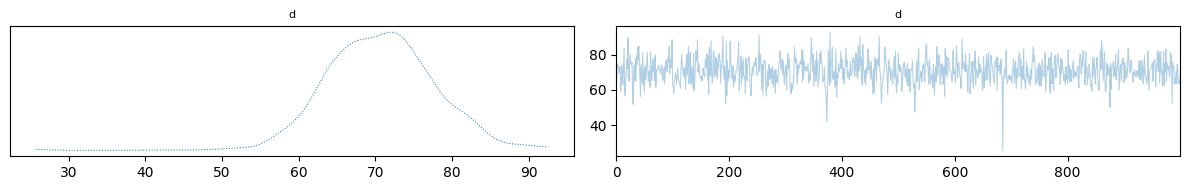

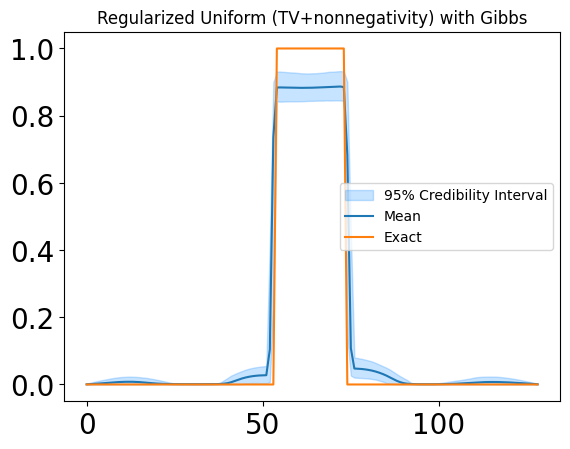

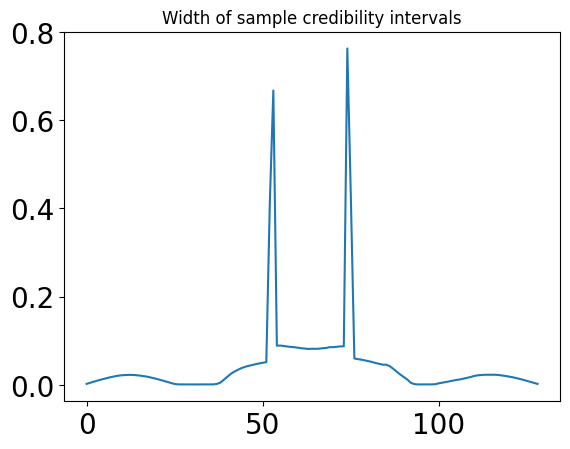

In [77]:
samples['d'].plot_trace()

plt.figure()
samples['x'].plot_ci()
plt.plot(x_exact, label='Exact')
plt.legend()
plt.title("Regularized Uniform (TV+nonnegativity) with Gibbs")

plt.figure()
samples['x'].plot_ci_width()